In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
import os 

### Ring buffer implementation

For behaviors: Gå gjennom en sortert liste med data (radene skal være sortert på tid). Så gå gjennom impressions-listen. Der det er en -"1", legg til artikkelens ID i ring-buffer (dette er en artikkel som brukeren har trykket på). 

Så ser vi på neste bruker/rad, som nå er ukjent, siden det er utenfor tidsvinduet. Vi ser tilbake n plsser i bufferet, og gir dette som impressions til denne brukeren. Deretter sjekker vi om det denne brukeren faktisk hadde en 1er på i sin impressionliste var noen av artiklene vi anbefalte. 

Et problem: vi vet ikke hvilken nettavis brukerne tilhører, og vi ikek hvordan impression-listen de faktisk fikk ble generert. To brukere kan komme etter hverandre på listen av brukere når vi sorterer på tid, og lese artikler på to helt forskjellige nettaviser. Dette vil i såfall gi lav score på evalueringen.

In [2]:
#path to the mindsmall training data
training_dataset = '../MINDsmall_train'

validation_dataset = '../MINDsmall_train'

entity_embedding = pd.read_csv("../MINDsmall_train/entity_embedding.vec", sep='\t')
relation_embedding = pd.read_csv("../MINDsmall_train/relation_embedding.vec", sep='\t')


news_data = pd.read_csv("../MINDsmall_train/news.tsv",
    sep='\t',
    names=["newsId", "category", "subcategory", "title","abstract", "url", "title_entities","abstract_entities"]
)

behaviors_data = pd.read_csv(
    "../MINDsmall_train/behaviors.tsv",
    sep='\t',
    names=["impressionId", "userId", "timestamp", "click_history", "impressions"],
    parse_dates=['timestamp'] 
)

### Preprocess data

In [3]:
behaviors_data['timestamp'] = pd.to_datetime(behaviors_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
behaviors_data['clicks'] = behaviors_data['click_history'].str.split().str.len()
behaviors_data['impressions_list'] = behaviors_data['impressions'].str.split()
behaviors_data['impressions_count'] = behaviors_data['impressions_list'].str.len()

# remove null values
news_data = news_data.dropna().reset_index(drop=True)


### Manglende verdier for clicks og click_history

In [4]:
null_clicks_rows = behaviors_data[behaviors_data['clicks'].isnull() & behaviors_data['click_history'].isnull()]

# Remove the rows with null values
behaviors_data = behaviors_data.dropna().reset_index(drop=True)

In [5]:
news_data.head()

newsId   category      subcategory  \
0  N55528  lifestyle  lifestyleroyals   
1  N19639     health       weightloss   
2  N61837       news        newsworld   
3  N53526     health           voices   
4  N38324     health          medical   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1                      50 Worst Habits For Belly Fat   
2  The Cost of Trump's Aid Freeze in the Trenches...   
3  I Was An NBA Wife. Here's How It Affected My M...   
4  How to Get Rid of Skin Tags, According to a De...   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  These seemingly harmless habits are holding yo...   
2  Lt. Ivan Molchanets peeked over a parapet of s...   
3  I felt like I was a fraud, and being an NBA wi...   
4  They seem harmless, but there's a very good re...   

                                             url  \
0  https://assets.msn.com/labs/mind/AAGH0ET.html   
1  https://assets.msn.com/labs/mind/AAB19MK.html   
2  https://assets.msn.com/labs/mind/AAJgNsz.html   
3  https://assets.msn.com/labs/mind/AACk2N6.html   
4  https://assets.msn.com/labs/mind/AAAKEkt.html   

                                      title_entities  \
0  [{"Label": "Prince Philip, Duke of Edinburgh",...   
1  [{"Label": "Adipose tissue", "Type": "C", "Wik...   
2                                                 []   
3                                                 []   
4  [{"Label": "Skin tag", "Type": "C", "WikidataI...   

                                   abstract_entities  
0                                                 []  
1  [{"Label": "Adipose tissue", "Type": "C", "Wik...  
2  [{"Label": "Ukraine", "Type": "G", "WikidataId...  
3  [{"Label": "National Basketball Association", ...  
4  [{"Label": "Skin tag", "Type": "C", "WikidataI...

In [6]:
behaviors_data.head()

impressionId  userId           timestamp  \
0             1  U13740 2019-11-11 09:05:58   
1             2  U91836 2019-11-12 18:11:30   
2             3  U73700 2019-11-14 07:01:48   
3             4  U34670 2019-11-11 05:28:05   
4             5   U8125 2019-11-12 16:11:21   

                                       click_history  \
0  N55189 N42782 N34694 N45794 N18445 N63302 N104...   
1  N31739 N6072 N63045 N23979 N35656 N43353 N8129...   
2  N10732 N25792 N7563 N21087 N41087 N5445 N60384...   
3  N45729 N2203 N871 N53880 N41375 N43142 N33013 ...   
4                        N10078 N56514 N14904 N33740   

                                         impressions  clicks  \
0                                  N55689-1 N35729-0     9.0   
1  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...    82.0   
2  N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...    16.0   
3                N35729-0 N33632-0 N49685-1 N27581-0    10.0   
4  N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...     4.0   

                                    impressions_list  impressions_count  
0                               [N55689-1, N35729-0]                  2  
1  [N20678-0, N39317-0, N58114-0, N20495-0, N4297...                 11  
2  [N50014-0, N23877-0, N35389-0, N49712-0, N1684...                 36  
3           [N35729-0, N33632-0, N49685-1, N27581-0]                  4  
4  [N39985-0, N36050-0, N16096-0, N8400-1, N22407...                 69

In [7]:
# sort behaviors_data by timestamp
behaviors_data = behaviors_data.sort_values(by='timestamp')

In [8]:
behaviors_data.head()

impressionId  userId           timestamp  \
19705          20112  U65916 2019-11-09 00:00:19   
13531          13807  U49985 2019-11-09 00:01:13   
27115          27660  U25550 2019-11-09 00:02:44   
149080        152217  U19710 2019-11-09 00:02:50   
41348          42166  U38106 2019-11-09 00:03:09   

                                            click_history  \
19705   N51706 N40767 N12096 N9798 N38802 N54827 N5780...   
13531   N5056 N29975 N53234 N39603 N50032 N8422 N53580...   
27115     N17260 N38298 N33976 N47719 N14888 N18870 N4607   
149080  N3530 N48284 N43019 N62546 N138 N13138 N10676 ...   
41348                           N16874 N264 N48697 N51366   

                                              impressions  clicks  \
19705   N54300-0 N46057-1 N57005-0 N52154-0 N57099-0 N...    15.0   
13531   N20602-0 N50059-0 N57768-1 N50135-1 N15134-0 N...    93.0   
27115        N50135-0 N15134-0 N52433-1 N20602-0 N64536-0     7.0   
149080  N57099-0 N30295-0 N21086-0 N5379-0 N57005-0 N4...     8.0   
41348   N3491-0 N20602-0 N25785-0 N23575-0 N38783-0 N1...     4.0   

                                         impressions_list  impressions_count  
19705   [N54300-0, N46057-1, N57005-0, N52154-0, N5709...                 31  
13531   [N20602-0, N50059-0, N57768-1, N50135-1, N1513...                 29  
27115   [N50135-0, N15134-0, N52433-1, N20602-0, N6453...                  5  
149080  [N57099-0, N30295-0, N21086-0, N5379-0, N57005...                 56  
41348   [N3491-0, N20602-0, N25785-0, N23575-0, N38783...                 48

### Ring buffer

In [9]:
class RingBuffer:
    """ Ring buffer class. """
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.impressions = []

    class __Full:
        """ Full buffer."""
        def add(self, x):
            """ Append an element overwriting the oldest one."""
            self.impressions[self.pointer] = x
            self.pointer = (self.pointer+1) % self.buffer_size

        def get(self):
            """ Return list of elements in correct order."""
            return self.impressions[self.pointer:] + self.impressions[:self.pointer]

    def add(self,x):
        """ Add impression to the end of the list."""
        self.impressions.append(x)
        if len(self.impressions) == self.buffer_size:
            self.pointer = 0
            # from now on, self.__class__ refers to the __Full class
            self.__class__ = self.__Full

    def get(self):
        """ Returns the list of impressions."""
        return self.impressions


### Add a user's impressions to the buffer

We go through the dataframe that is sorted on the timestamps. The ring buffer is instantiated, and we don't start recommending articles until we have gone through a couple of users so that the buffer has a couple of articles in it. Then we check if the recommendation from the ring buffer match up with the actual impression list for the rest of the users. 

In [10]:
wait_count = 10
max_users = wait_count + 1000
last_user = 0
buffer_size = 20
ring_buffer = RingBuffer(buffer_size=buffer_size)
recommendation_size = 20

hits = 0
total_rows = 0

actual_impressions = []
recommended_impressions = []

for index, row in behaviors_data.iterrows():

    user_impressions = []

    if row['impressions_count'] > 0 and max_users > 0:
        user = row['userId']
        #the articles that the user clicked on
        [user_impressions.append(n.split("-")[0]) for n in row['impressions_list'] if n.split("-")[1] == "1"]

        # we wait for users to click on articles before we start recommending articles
        if wait_count == 0:
            # recommend the articles that are in the buffer 
            recommended_impressions.append((user, set(ring_buffer.get()[:recommendation_size])))
            # store the actual articles that the user clicked on
            actual_impressions.append((user, set(user_impressions)))

        #add the current user clicks to the buffer
        for impression in user_impressions:
            ring_buffer.add(impression)

    wait_count -= 1 if wait_count > 0 else 0
    # we can remove this condition to get all the users
    # max_users -= 1
    if max_users == 0:
        break

### Evaluate the Ring Buffer

In [11]:
def evaluate_ring_buffer(actual, recommended):
    total_hits = 0
    print(f'Number of entries evaluated: {len(actual)}')

    hit_rate_list = []

    for i in range(len(actual)):
        length = i + 1
        print(f'{(total_hits / length) * 100: 2f}%')
        hit_rate_list.append((total_hits / length) * 100)
        # measure the accuracy of the recommendation
        intersection = actual[i][1].intersection(recommended[i][1])
        if len(intersection) > 0:
            total_hits += 1
        # print(f'Actual clicks for user {actual[i][0]}: {actual[i][1]}')
        # print(f'Recommended articles: {recommended[i][1]}')
        
    # calculate the accuracy
    hit_rate = (total_hits / len(actual) * 100)
    print(f'Hit rate: {hit_rate}%')
    return hit_rate_list



results = evaluate_ring_buffer(actual_impressions, recommended_impressions)
print(f'Actual impressions: {actual_impressions}')


Number of entries evaluated: 153717
 0.000000%
 50.000000%
 33.333333%
 50.000000%
 40.000000%
 50.000000%
 57.142857%
 50.000000%
 55.555556%
 60.000000%
 54.545455%
 50.000000%
 53.846154%
 50.000000%
 46.666667%
 43.750000%
 47.058824%
 44.444444%
 47.368421%
 45.000000%
 47.619048%
 50.000000%
 47.826087%
 45.833333%
 44.000000%
 46.153846%
 44.444444%
 42.857143%
 44.827586%
 46.666667%
 48.387097%
 50.000000%
 51.515152%
 50.000000%
 48.571429%
 47.222222%
 45.945946%
 44.736842%
 43.589744%
 42.500000%
 43.902439%
 42.857143%
 41.860465%
 40.909091%
 42.222222%
 43.478261%
 42.553191%
 43.750000%
 42.857143%
 42.000000%
 43.137255%
 42.307692%
 43.396226%
 44.444444%
 45.454545%
 44.642857%
 43.859649%
 44.827586%
 44.067797%
 45.000000%
 44.262295%
 45.161290%
 46.031746%
 46.875000%
 46.153846%
 45.454545%
 44.776119%
 45.588235%
 44.927536%
 44.285714%
 43.661972%
 44.444444%
 43.835616%
 43.243243%
 42.666667%
 42.105263%
 42.857143%
 43.589744%
 43.037975%
 43.750000%
 44.4

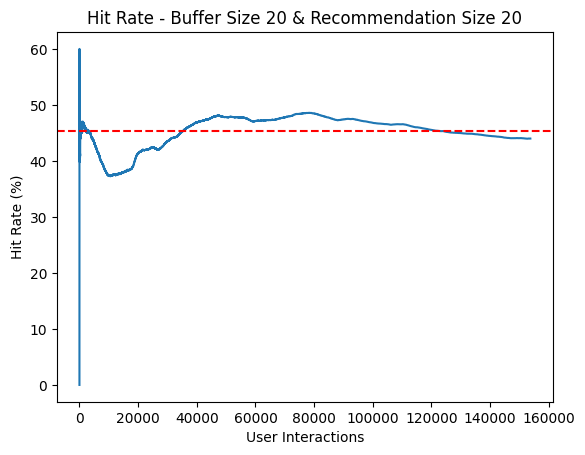

In [12]:
# plot the hit rate
import matplotlib.pyplot as plt
size = recommendation_size
plt.title(f'Hit Rate - Buffer Size {buffer_size} & Recommendation Size {recommendation_size}')

plt.plot(results)
plt.ylabel('Hit Rate (%)')
plt.xlabel('User Interactions')

#draw a line at the average hit rate
plt.axhline(y=sum(results) / len(results), color='r', linestyle='--')
plt.text(0, sum(results) / len(results), "",color='r')


plt.show()




In [13]:
def calculate_precision_recall_k(actual, recommended, k):
    precision_k_accum, recall_k_accum = [], []
    for act, rec in zip(actual, recommended):
        rec_k = list(rec[1])[:k]  
        act_set = act[1]
        rec_set = set(rec_k)
        
        true_positives = len(act_set & rec_set)
        precision_k = true_positives / k
        recall_k = true_positives / len(act_set) if act_set else 0
        
        precision_k_accum.append(precision_k)
        recall_k_accum.append(recall_k)
    return np.mean(precision_k_accum), np.mean(recall_k_accum)

def calculate_mrr(actual, recommended):
    mrr_accum = []
    for act, rec in zip(actual, recommended):
        act_set = act[1]
        rec_list = list(rec[1])
        
        rank = next((1 / (rec_list.index(item) + 1) for item in rec_list if item in act_set), 0)
        mrr_accum.append(rank)
    return np.mean(mrr_accum)

k = 5
precision_k, recall_k = calculate_precision_recall_k(actual_impressions, recommended_impressions, k)
mrr = calculate_mrr(actual_impressions, recommended_impressions)

print(f'Precision@{k}: {precision_k}')
print(f'Recall@{k}: {recall_k}')
print(f'MRR: {mrr}')









Precision@5: 0.03140706623210185
Recall@5: 0.11859027860062153
MRR: 0.09632758699292393
